In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# load data
df = pd.read_csv(r"D:\Coding\Energy-Management_Project\data\data_15min.csv")

# show data
df.head(10)

In [ ]:
# convert utc timestamp to datetime format

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])  # Convert to datetime
df.set_index('utc_timestamp', inplace=True)  # Set as index

In [ ]:
df.index.dtype

In [ ]:
# checking missing values

df.isna().sum()

In [ ]:
# interpolation or forward fill

df.interpolate(method='time', inplace=True)  # Time-based interpolation
df.fillna(method='ffill', inplace=True)  # Forward fill


In [ ]:
# checking missing values

df.isna().sum()

## Column Operations

In [ ]:
# replace "DE_KN_" from all column names

df.columns = df.columns.str.replace("DE_KN_", "", regex=True)


In [ ]:
df.columns

In [ ]:
# Renaming categories, e.g: industrial4 --> i4

import re

# Function to rename categories
def rename_category(col_name):
    col_name = re.sub(r"industrial(\d+)", r"i\1", col_name)  # industrialX → iX
    col_name = re.sub(r"public(\d+)", r"p\1", col_name)  # publicX → pX
    col_name = re.sub(r"residential(\d+)", r"r\1", col_name)  # residentialX → rX
    return col_name

# Apply renaming function to all column names
df.columns = [rename_category(col) for col in df.columns]


In [ ]:
df.columns

In [ ]:
# drop "unnamed" column

df.drop(columns=["Unnamed: 70"], inplace=True)


In [ ]:
df.columns

In [ ]:
# fill NaN with 0

df.fillna(0, inplace=True)


## Data Description

In [ ]:
# total values > 0 in each column

count = (df['p2_grid_import'] > 0).sum()
print(f"Number of rows where 'p2_grid_import' > 0: {count}")

count = (df['i2_grid_import'] > 0).sum()
print(f"Number of rows where 'i2_grid_import' > 0: {count}")


count = (df['i3_grid_import'] > 0).sum()
print(f"Number of rows where 'i3_grid_import' > 0: {count}")

count = (df['r1_grid_import'] > 0).sum()
print(f"Number of rows where 'r1_grid_import' > 0: {count}")

count = (df['r4_grid_import'] > 0).sum()
print(f"Number of rows where 'r4_grid_import' > 0: {count}")



In [ ]:
# data description

print(df.describe())

In [ ]:
#time series trends

df.plot(figsize=(12, 6), title="Time Series Trends")


In [ ]:
# Seasonal Decomposition Check
#Trend → Long-term increase/decrease in consumption.
#Seasonality → Repeating patterns (daily, weekly, yearly).
#Residuals → Random fluctuations.

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(df['r5_washing_machine'], model='additive', period=365)
result.plot()
plt.show()


In [ ]:
result = seasonal_decompose(df['r1_heat_pump'], model='additive', period=365)
result.plot()
plt.show()


## Model Building

### Prophet Algorithm

In [ ]:
from prophet import Prophet

In [ ]:
# Prepare DataFrame for Prophet: reset index to get datetime as column 'ds'

df_prophet = df[['r6_washing_machine']].copy()  # take only target col
df_prophet['ds'] = df_prophet.index  # move index to column

In [ ]:
# Remove timezone info from 'ds' column
df_prophet['ds'] = df_prophet['ds'].dt.tz_convert(None)

In [ ]:
# Rename target column to 'y' as Prophet expects
df_prophet = df_prophet.rename(columns={'r6_washing_machine': 'y'})

In [ ]:
# Filter training data: 1 month data from Jan 2016
train_1m = df_prophet[(df_prophet['ds'] >= '2016-01-01') & (df_prophet['ds'] < '2016-02-01')]


In [ ]:
print(f"Training data shape: {train_1m.shape}")
print(train_1m.head())

In [ ]:
# Initialize Prophet model with daily and weekly seasonality (yearly off for short data)
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)


In [ ]:
# Fit model
model.fit(train_1m)


In [ ]:
# Create future dataframe for next 2 days (15-min freq, 96 intervals per day)
future = model.make_future_dataframe(periods=96*2, freq='15min')

In [ ]:
# Predict future usage
forecast = model.predict(future)


In [ ]:
# Plot forecast
model.plot(forecast)
plt.title('r6_washing_machine usage forecast (1 month train, 2 days predict)')
plt.show()

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

# Assuming you already have your trained model and forecast dataframe:

# Plot the main forecast plot (optional, if not already done)
model.plot(forecast)

# Plot the forecast components (trend, weekly and daily seasonality)
model.plot_components(forecast)


### XGBoost Model

In [ ]:
# select target column

df_model = df[['r6_washing_machine']].copy()
df_model.rename(columns={'r6_washing_machine': 'y'}, inplace=True)


In [ ]:
# filter training and test data
# Remove timezone if needed
df_model.index = df_model.index.tz_localize(None)

# Create features on full df_model first
df_features = create_features(df_model.copy())

# Drop NA caused by lag features
df_features.dropna(inplace=True)

# Then split train/test on features df
train_feat = df_features['2017-01-01':'2017-01-31']
test_feat = df_features['2017-02-01':'2017-02-02']



In [ ]:
# drop NA from Lag features

train_feat.dropna(inplace=True)
test_feat.dropna(inplace=True)

In [ ]:
# split

X_train = train_feat.drop(columns='y')
y_train = train_feat['y']
X_test = test_feat.drop(columns='y')
y_test = test_feat['y']

In [ ]:
# train XGBoost

from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

In [ ]:
# predict and plot

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Forecast of r6_washing_machine (XGBoost)')
plt.show()


In [ ]:
print("Test data shape:", test_feat.shape)
print(test_feat.head())
print(test_feat.tail())


In [ ]:
print("Zero count:", (df_model['y'] == 0).sum())
print("Total samples:", len(df_model))


In [ ]:
train['y'].plot(label="Train", figsize=(15,4))
test['y'].plot(label="Test")
plt.legend()
plt.title("Train vs Test target values")
plt.show()


In [ ]:
df_features.corr()['y'].sort_values(ascending=False)


In [ ]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, label="Predicted")
plt.title("Predicted values")
plt.legend()
plt.show()


### possible solution

In [ ]:
# Work on a copy of the full data
df_model = df[['r6_washing_machine']].copy()
df_model = df_model.rename(columns={"r6_washing_machine": "y"})




In [ ]:
#Create lag features BEFORE splitting
def create_features(df):
    df['lag_1'] = df['y'].shift(1)
    df['lag_2'] = df['y'].shift(2)
    df['lag_4'] = df['y'].shift(4)
    df['lag_96'] = df['y'].shift(96)   # 1 day before (15 min freq)
    df['lag_672'] = df['y'].shift(672) # 1 week before

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    return df

df_feat_all = create_features(df_model.copy())
df_feat_all.dropna(inplace=True)



In [ ]:
# split the data
train_feat = df_feat_all['2015-11-01':'2015-11-30']
test_feat  = df_feat_all['2015-12-01':'2015-12-02']

X_train = train_feat.drop(columns='y')
y_train = train_feat['y']

X_test  = test_feat.drop(columns='y')
y_test  = test_feat['y']

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
plt.figure(figsize=(15,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Consumption")
plt.show()


In [ ]:
df_features.corr()['y'].sort_values(ascending=False)

## XGBoost with Lag Features

In [1]:
import numpy as np
import pandas as pd

In [2]:


df2 = pd.read_csv(r'D:\Coding\Energy-Management_Project\data\data_15min.csv')
df2.head(10)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,Unnamed: 70
0,2014-12-11T17:45:00Z,2014-12-11T18:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-11T18:00:00Z,2014-12-11T19:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-11T18:15:00Z,2014-12-11T19:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-11T18:30:00Z,2014-12-11T19:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-11T18:45:00Z,2014-12-11T19:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-11T19:00:00Z,2014-12-11T20:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-12-11T19:15:00Z,2014-12-11T20:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-12-11T19:30:00Z,2014-12-11T20:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-12-11T19:45:00Z,2014-12-11T20:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-12-11T20:00:00Z,2014-12-11T21:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Parse datetime and set index

df2['utc_timestamp'] = pd.to_datetime(df2['utc_timestamp'])
df2.set_index('utc_timestamp', inplace=True)

In [4]:
# Rename target column to 'r6_wm'

df2.rename(columns={"DE_KN_residential6_washing_machine": "r6_wm"}, inplace=True)

In [7]:
# Keep only timestamp and target

df2 = df2[["cet_cest_timestamp", "r6_wm"]]


In [8]:
# Sort by timestamp ascending

df2 = df2.sort_values("utc_timestamp").reset_index(drop=True)

In [9]:
# Handle missing values (forward fill, then backward fill)

df2["r6_wm"].fillna(method="ffill", inplace=True)
df2["r6_wm"].fillna(method="bfill", inplace=True)

C:\Users\rrous\AppData\Local\Temp\ipykernel_31532\2341466300.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["r6_wm"].fillna(method="ffill", inplace=True)
C:\Users\rrous\AppData\Local\Temp\ipykernel_31532\2341466300.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2["r6_wm"].fillna(method="ffill", inplace=True)
C:\Users\rrous\AppData\Local\Temp\ipykernel_31532\2341466300.py:4: FutureWarning: A value is trying to be set on a co

In [73]:
# Create lag features (1 lag = 15 min, 4 lags = 1 hour, 96 lags = 1 day, 672 lags = 1 week)

df2["lag_1"] = df2["r6_wm"].shift(1)
df2["lag_4"] = df2["r6_wm"].shift(4)
df2["lag_96"] = df2["r6_wm"].shift(96)
df2["lag_672"] = df2["r6_wm"].shift(672)

In [ ]:
# Create rolling features on full df2 (shift to avoid leakage)

df2['rolling_mean_4h'] = df2['r6_wm'].rolling(window=16).mean().shift(1)  # 4 hours rolling mean, shifted
df2['rolling_std_4h'] = df2['r6_wm'].rolling(window=16).std().shift(1)
df2['rolling_mean_1d'] = df2['r6_wm'].rolling(window=96).mean().shift(1)  # 1 day rolling mean, shifted
df2['rolling_std_1d'] = df2['r6_wm'].rolling(window=96).std().shift(1)

In [ ]:
# Drop rows with NaNs introduced by rolling calculations

df2 = df2.dropna(subset=['rolling_mean_4h', 'rolling_std_4h', 'rolling_mean_1d', 'rolling_std_1d'])

#removes the initial rows that don’t have enough past data to compute the rolling statistics
#makes the dataset ready for model training without missing values.

In [118]:
# Define train and test date ranges

train_start = pd.Timestamp("2016-01-01")
train_end = pd.Timestamp("2017-04-30")
test_start = pd.Timestamp("2017-05-01")
test_end = pd.Timestamp("2017-05-10")

In [119]:
# Filter train and test data
train_mask = (df2["cet_cest_timestamp"] >= train_start) & (df2["cet_cest_timestamp"] <= train_end)
test_mask = (df2["cet_cest_timestamp"] >= test_start) & (df2["cet_cest_timestamp"] <= test_end)


In [120]:
train_data = df2.loc[train_mask].copy()
test_data = df2.loc[test_mask].copy()

In [121]:
# Add time-based features

for df in [train_data, test_data]:
    df['month'] = df['cet_cest_timestamp'].dt.month
    df['day_of_year'] = df['cet_cest_timestamp'].dt.dayofyear
    df['weekday'] = df['cet_cest_timestamp'].dt.weekday

In [122]:
# Features and target columns (exclude datetime and target)

exclude_cols = ['cet_cest_timestamp', 'r6_wm']
feature_cols = [col for col in df2.columns if col not in ["cet_cest_timestamp", "r6_wm"]]

In [123]:
X_train = train_data[feature_cols]
y_train = train_data["r6_wm"]

X_test = test_data[feature_cols]
y_test = test_data["r6_wm"]

In [124]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [125]:
# Train XGBoost model

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [126]:
# Predict on test set

y_pred = model.predict(X_test)

In [127]:
# Evaluate

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.6284


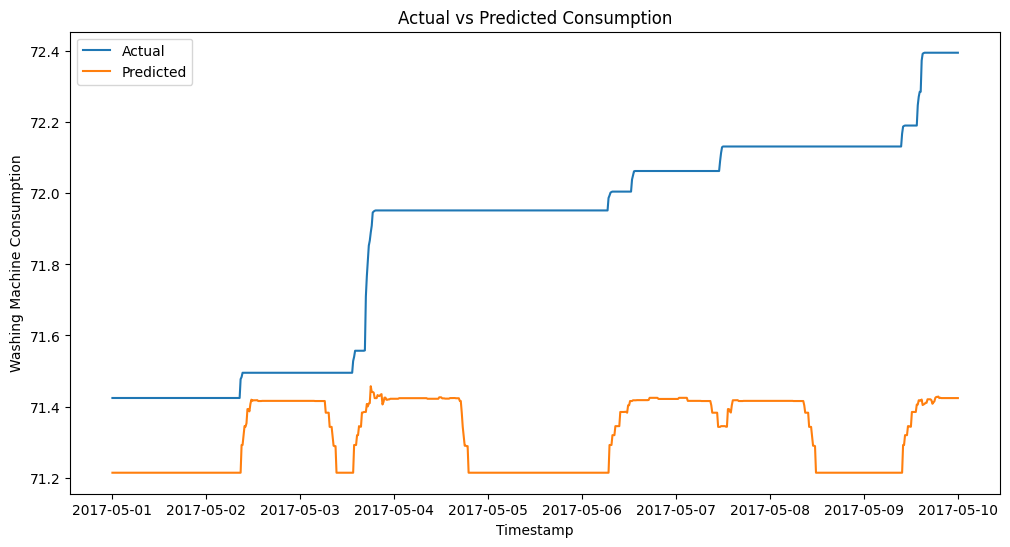

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_data["cet_cest_timestamp"], y_test, label="Actual")
plt.plot(test_data["cet_cest_timestamp"], y_pred, label="Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Washing Machine Consumption")
plt.title("Actual vs Predicted Consumption")
plt.legend()
plt.show()


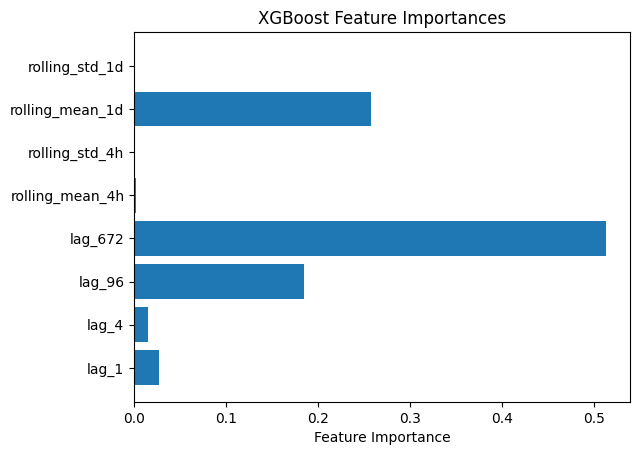

In [112]:
import matplotlib.pyplot as plt

plt.barh(feature_cols, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.show()


In [113]:
print(X_test.describe())


       lag_1  lag_4  lag_96  lag_672  rolling_mean_4h  rolling_std_4h  \
count    0.0    0.0     0.0      0.0              0.0             0.0   
mean     NaN    NaN     NaN      NaN              NaN             NaN   
std      NaN    NaN     NaN      NaN              NaN             NaN   
min      NaN    NaN     NaN      NaN              NaN             NaN   
25%      NaN    NaN     NaN      NaN              NaN             NaN   
50%      NaN    NaN     NaN      NaN              NaN             NaN   
75%      NaN    NaN     NaN      NaN              NaN             NaN   
max      NaN    NaN     NaN      NaN              NaN             NaN   

       rolling_mean_1d  rolling_std_1d  
count              0.0             0.0  
mean               NaN             NaN  
std                NaN             NaN  
min                NaN             NaN  
25%                NaN             NaN  
50%                NaN             NaN  
75%                NaN             NaN  
max           

In [114]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())


lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64


In [99]:
print(len(train_data), len(test_data))


14497 865


In [115]:
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
print(results.tail())


Empty DataFrame
Columns: [actual, predicted]
Index: []


In [116]:
# Check for nulls in features
print("Train features missing values:\n", X_train.isnull().sum())
print("Test features missing values:\n", X_test.isnull().sum())

# Check data shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Check train and test date ranges
print("Train date range:", train_data['cet_cest_timestamp'].min(), "to", train_data['cet_cest_timestamp'].max())
print("Test date range:", test_data['cet_cest_timestamp'].min(), "to", test_data['cet_cest_timestamp'].max())

# Check target distributions
print("Train target stats:\n", y_train.describe())
print("Test target stats:\n", y_test.describe())


Train features missing values:
 lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
Test features missing values:
 lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
Train shape: (116825, 8), Test shape: (0, 8)
Train date range: 2016-01-01 00:00:00 to 2019-05-01 22:00:00
Test date range: NaT to NaT
Train target stats:
 count    116825.000000
mean         62.305955
std          22.353329
min           8.777000
25%          42.273000
50%          78.641000
75%          78.641000
max          78.641000
Name: r6_wm, dtype: float64
Test target stats:
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: r6_wm, dtype: float64


## Analyzing Feature behaviour

In [129]:
# Narrow down the test range to zoom in on the jump period

analysis_start = pd.Timestamp("2017-05-01")
analysis_end = pd.Timestamp("2017-05-10")

analysis_data = test_data[
    (test_data['cet_cest_timestamp'] >= analysis_start) &
    (test_data['cet_cest_timestamp'] <= analysis_end)
].copy()

analysis_data['y_true'] = y_test.loc[analysis_data.index]
analysis_data['y_pred'] = y_pred  # ensure y_pred is aligned


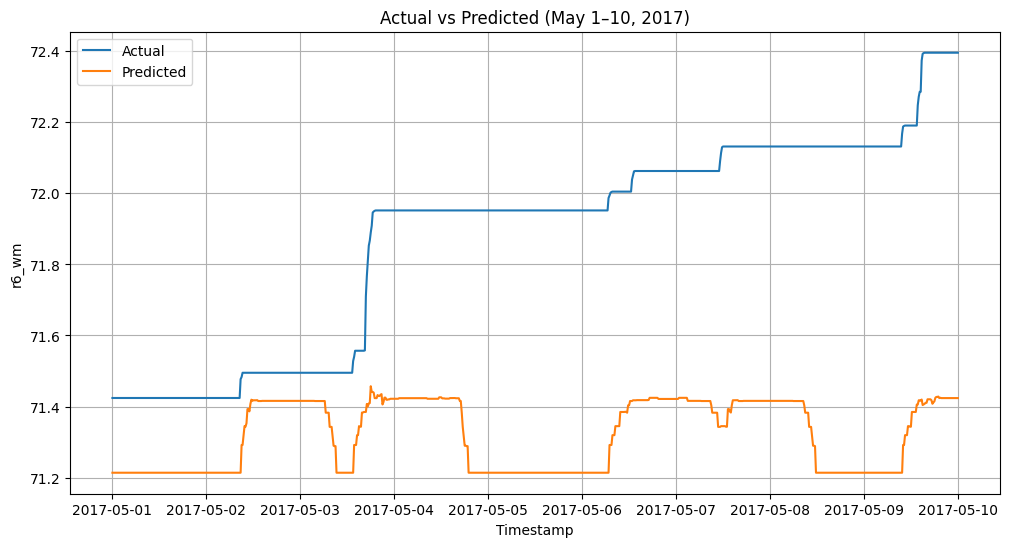

In [130]:


plt.figure(figsize=(12, 6))
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['y_true'], label='Actual')
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['y_pred'], label='Predicted')
plt.title('Actual vs Predicted (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('r6_wm')
plt.legend()
plt.grid(True)
plt.show()


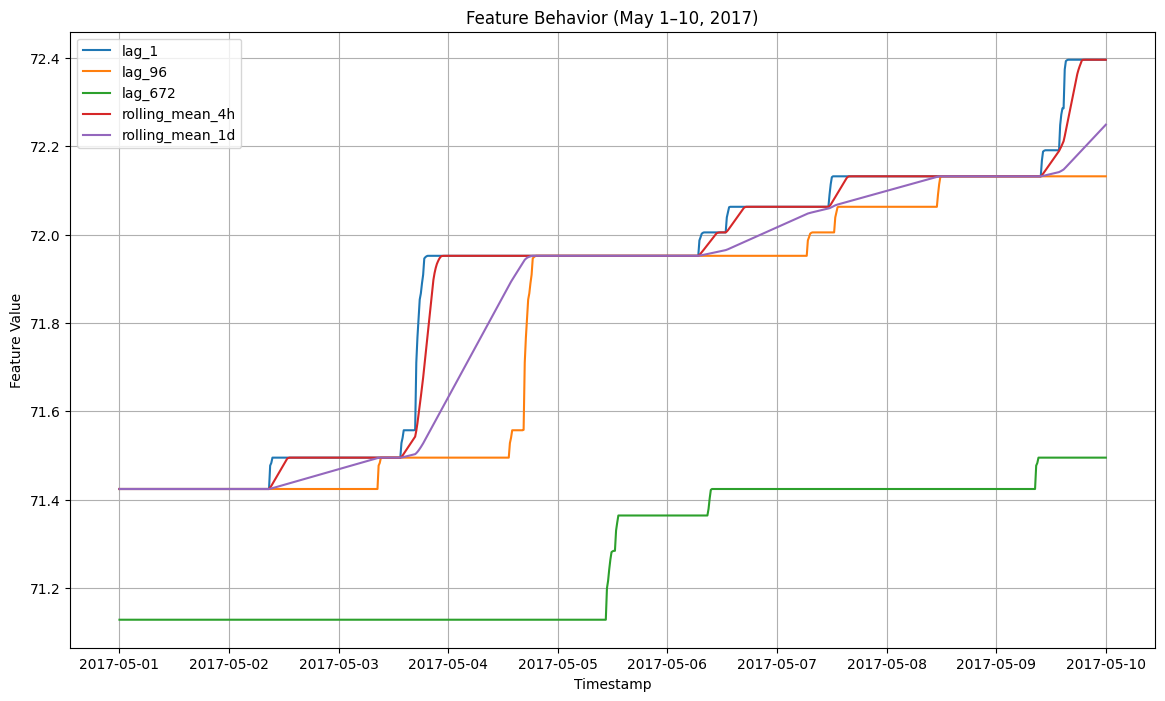

In [131]:
# plot feature behaviour over time

feature_subset = ['lag_1', 'lag_96', 'lag_672', 'rolling_mean_4h', 'rolling_mean_1d']

plt.figure(figsize=(14, 8))
for feature in feature_subset:
    plt.plot(analysis_data['cet_cest_timestamp'], analysis_data[feature], label=feature)

plt.title('Feature Behavior (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()


In [132]:
# correltion check

corr_matrix = analysis_data[feature_subset + ['y_pred']].corr()
print(corr_matrix['y_pred'].sort_values(ascending=False))


y_pred             1.000000
lag_1              0.285237
rolling_mean_4h    0.263891
lag_672            0.171578
rolling_mean_1d    0.126056
lag_96            -0.020177
Name: y_pred, dtype: float64


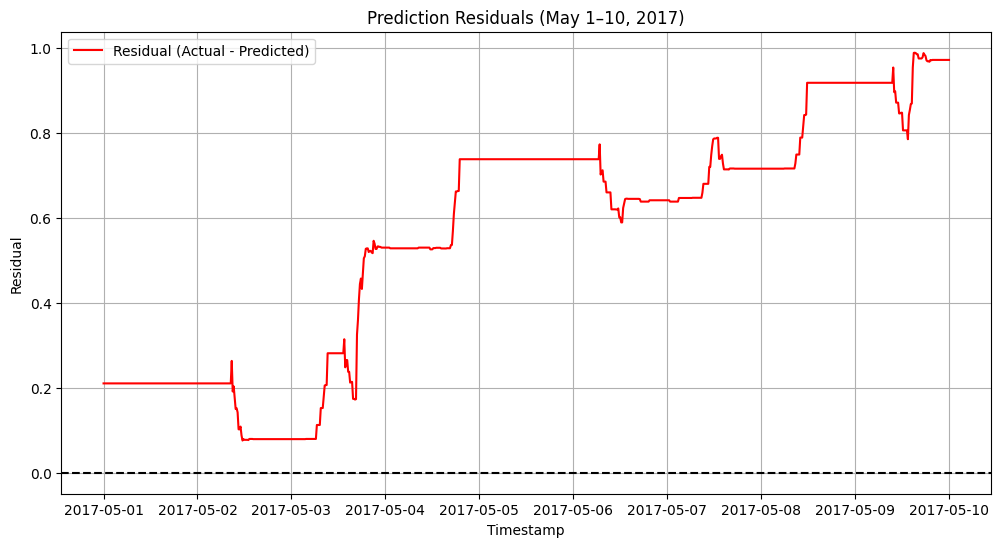

In [133]:
# viz residuals

analysis_data['residual'] = analysis_data['y_true'] - analysis_data['y_pred']

plt.figure(figsize=(12,6))
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['residual'], label='Residual (Actual - Predicted)', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Prediction Residuals (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()
